### Importando Pacotes e Baixando Dataset

In [129]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

O dataset utilizado nesse tutorial pode ser baixado diretamente do tensorflow.
Outra opção é utilizar o disponível no site "https://www.kaggle.com/c/digit-recognizer" ou utilizando o comando "kaggle competitions download -c digit-recognizer" no prompt de comando (note que é necessario executar "pip install --upgrade kaggle" antes para poder chamar a função kaggle). Neste exemplo, as bases estão no folder "data".

In [49]:
# outter dataset: from kaggle

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# From tensorflow accessing the same dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [50]:
# Aqui iremos separar os datasets de treino e de teste:
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

### Explorando as bases 

Aqui podemos dar uma olhada no formato de cada uma das bases. Note que as bases x's possuem 784 colunas, o que significa que a imagem possui 784 pixels em escala cinza. Já as bases y's possuem apenas uma coluna que é o label (classe) de cada imagem. Por fim, a unica diferença entre as bases tipo "train" e "test" é o número de amostras.

In [51]:
print("Train shape:")
print(x_train.shape)
print(y_train.shape)
print("\nTest shape:")
print(x_test.shape)
print(y_test.shape)

Train shape:
(55000, 784)
(55000,)

Test shape:
(10000, 784)
(10000,)


Aqui iremos plotar uma das imagens para que possamos conhecer melhor a base. É importante observar que os dados estão dispostos em um único vetor, então será necessário aplicar a função "reshape" para vizualizar a imagem 2D.

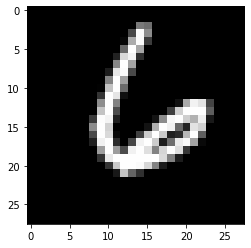

In [52]:
# Tente mudar o numero do índice para ver diferentes números na imagem
# Obs: também é possível variar entre as bases
rdm_img = x_train[25004]

rdm_img = rdm_img.reshape((28,28))
plt.imshow(rdm_img, cmap='gray')
plt.show()

### Construindo a rede DNN (Deconvultional Neural Network)

Aqui iremos construir uma rede do tipo Deconvultional Neural Network. Se quiser se aprofundar mais nos tipos de redes neurais eu recomendo fortemente o site "http://www.asimovinstitute.org/neural-network-zoo/". Lá você verá que esse não é o tipo de rede mais recomendado para esse tipo de classificação, pois é pouco perfomático (lento para processar esse tipo de dado). O ideal seria utilizar uma rede do tipo convulsional, porém o dataset em questão é bem simples, o que permite essa abordagem.

Vale pontuar que estamos trabalhando com aprendizagem do tipo supervisionada, ou seja, nos sabemos quais são as classificações existentes e cada dado de treino está associado a uma classe.

Chamamos de features todas as variáveis que exceto a Classe. Elas são as nossas informações de entrada e é com elas que o algorítimo "aprenderá" a ler a imagem.

Um estimator é uma API de alto nível que, no caso, simplifica a criação de uma rede neural no tensorflow. Você pode encontrar mais detalhes em "https://www.tensorflow.org/guide/estimators". <div>
Os Parâmetros usados serão:
- feature_columns : Determina o formato das colunas de treino
- hidden_units : Número de neuronios por camada
- activation_fn : Função de ativação dos neurônios (https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
- optimizer : otimizador https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer com taxa de aprendizagem (https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)
- n_classes : Número de classes da base (10 no caso)
- dropout : "Desliga" eventualmente uma porcentagem de neurônios, evitando overfitting
- model_dir : Diretório onde irá salvar os checkpoints do modelo

In [61]:
# Ensinando o tipo de imagem que estamos lidando
feature_columns = [tf.feature_column.numeric_column("x", shape=[28,28])]

In [66]:
# Gerando o Classificador
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [256, 32],
    activation_fn = tf.nn.relu, # Função de ativação "relu"
    optimizer = tf.train.AdamOptimizer(1e-4),
    n_classes = 10,
    dropout = 0.1,
    model_dir = "./mnist_model"
)

Vamos definir uma função de input para ativar a rede. Os Parâmetros usados serão:
- x : features usadas para treino
- y : label
- num_epochs vs batch_size : sugiro ler https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 
- shuffle : Se queremos embaralhar a base ao treinar o dataset

In [67]:
# Input no formato de numpy_input_fn pq os dados estão em um numpy array
train_input_fun = tf.estimator.inputs.numpy_input_fn (
    x = {"x" : x_train},
    y = y_train.astype(np.int32),
    num_epochs = None,
    batch_size = 50,
    shuffle = True
)

### Treinando o modelo

Com todos os preparativos feitos, vamos simplesmente chamar a função "train_input_fun" no nosso classificador, elegendo o número de steps (que será o número de épocas de treino).

In [68]:
classifier.train(input_fn = train_input_fun, steps = 10000)

### Testando e avaliando o modelo

Vamos Primeiro criar uma função input com os dados de teste semelhante a "train_input_fun". Os dados "x" e "y" agora são referentes aos dados de treino, porém vamos rodar o modelo apenas 1 vez e não será necessário embaralhar os dados. <div>
Depois iremos salvar os resultados da avaliação do modelo para comparar com as classes verdadeiras.

In [69]:
test_input_fun = tf.estimator.inputs.numpy_input_fn (
    x = {"x" : x_test},
    y = y_test.astype(np.int32),
    num_epochs = 1,
    shuffle = False
)

In [70]:
results = classifier.evaluate(input_fn = test_input_fun)

W0821 14:23:10.725805  3032 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [74]:
# Printando Resultados

# print(results)
print("Precisão do teste: {0:f}%\n".format(results["accuracy"] * 100))

Precisão do teste: 96.990001%



Vamos agora gerar a matriz confusão. Ela nos mostrará com detalhes o número de classificações corretas e equivocadas para cada uma das classes. Não recomendo utilizar quando há muitas classes envolvidas, porém é interessante observar que o ideal é que a maioria das classificações se concentrem na diagonal principal.

In [108]:
previsoes = classifier.predict(input_fn = test_input_fun)
previsoes = list(previsoes)
prev = []
for n in range(len(previsoes)):
    prev.append(previsoes[n]['class_ids'][0])

In [134]:
matrix = confusion_matrix(
    y_true = y_test,
    y_pred = prev
)

In [135]:
matrix

array([[ 968,    0,    1,    2,    0,    2,    5,    1,    1,    0],
       [   0, 1121,    3,    2,    0,    1,    4,    1,    3,    0],
       [   7,    0, 1001,    3,    2,    1,    3,    6,    9,    0],
       [   0,    0,    6,  983,    1,    7,    0,    7,    5,    1],
       [   1,    0,    7,    0,  961,    0,    3,    2,    2,    6],
       [   2,    0,    0,   10,    3,  863,    6,    1,    4,    3],
       [   4,    3,    0,    1,    8,    4,  936,    0,    2,    0],
       [   1,    7,   10,    3,    3,    0,    0,  989,    1,   14],
       [   3,    2,    4,    9,    4,    5,    4,    7,  933,    3],
       [   5,    6,    1,   13,   22,    5,    1,   10,    2,  944]],
      dtype=int64)

Espero que esse caderno tenha te ajudado a começar a mexer com classificação de imagens. Bons estudos e muito código pra você. <3 <3